# EIP-4844 Fee Market Analysis: Simulation and Backtest

## Description

Proto-danksharding or [EIP-4844](https://eips.ethereum.org/EIPS/eip-4844) introduces a new transaction format for “blob-carrying transactions” which contain a large amount of data that cannot be accessed by EVM execution, but whose commitment can be accessed. The goal is to facilitate an ecosystem-wide move to rollups: Optimism and Arbitrum provide fees that are ~3-8x lower than the Ethereum base layer, and ZK rollups, which have better data compression and can avoid including signatures, have fees ~40-100x lower than the base layer.

The long-term scaling solution is still data sharding: add ~16 MB per block of dedicated data space to the chain that rollups could use. This EIP is an intermediate step which implements (1) same transaction format as sharding and (2) creates the gas fee market for this type of transactions, but has the following differences:

- No sharding of transactions: the data from blob transactions is fully downloaded by all consensus nodes (but can be deleted after only a relatively short delay)

- Reduced cap on the number of these transactions that can be included: target of ~0.25 MB per block and limit of ~0.5 MB

## Data Gas Fee Market

Data gas is introduced as a new type of gas that is only used to price blob transactions. It is independent of normal gas and follows its own targeting rule. The new pricing rule requires the `excess_data_gas` header field. The actual `data_fee` as calculated via `calc_data_fee` (see below) is deducted from the sender balance before transaction execution and burned, and is not refunded in case of transaction failure.

The data gasprice update rule approximates the formula

`data_gasprice = MIN_DATA_GASPRICE * e**(excess_data_gas / DATA_GASPRICE_UPDATE_FRACTION)`,

where `excess_data_gas` is the total “extra” amount of data gas that the chain has consumed relative to the “targeted” amount to date. Like EIP-1559, it’s a self-correcting formula: as the excess goes higher, the `data_gasprice` increases exponentially, reducing usage and eventually forcing the excess back down.

The block-by-block behavior is roughly as follows. If block `N` consumes `X` data gas, then in block `N+1` `excess_data_gas` increases by `X - TARGET_DATA_GAS_PER_BLOCK`, and so the `data_gasprice` of block `N+1` increases by a factor of 

`e**((X - TARGET_DATA_GAS_PER_BLOCK) / DATA_GASPRICE_UPDATE_FRACTION)`. 

Hence, it has a similar effect to the existing EIP-1559, but is more “stable” in the sense that it responds in the same way to the same total usage regardless of how it’s distributed.

The parameter `DATA_GASPRICE_UPDATE_FRACTION` controls the maximum rate of change of the blob gas price. It is chosen to target a maximum change rate of `e(TARGET_DATA_GAS_PER_BLOCK / DATA_GASPRICE_UPDATE_FRACTION) ≈ 1.125` per block.

## Setup

`Transaction` class:

- `max_fee_per_gas`: the max price that user is willing to pay.
- `max_priority_fee_per_gas`: the tip to the block producers.
- `gas_used`: gas resource required to execute transaction.

`BlobTransaction(Transaction)` class:

- `max_fee_per_data_gas`: the max data gasprice that user is willing to pay.
- `blob_hashes`: number of blobs included in transaction.


`generate_demand` function: generates demand for transactions. This is defined in each simulation instance as assumptions change.

`update_price` function: calculate resource prices using EIP-1559 formula according do deviation vs sustainable _resource target_: `new_price = price * (1 + ((utilized - target) / target) / 8)`.

`update_excess_data_gas` function: the excess data gas consumed (above the sustainable target) is computed according to the gas accounting formulas for blobs specified in the EIP.

`build_block` function: selects transactions, steps (1) filter out invalid txns for which gahimit is not enough and (2) build block respecting _resource limits_. Greedy block building logic where builder sorts by total gas premium and then selects transactions up to resource limit.

In [1]:
import secrets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
constants = {
    # 1559 fee mechanism params 
    "BLOCK_RESOURCE_LIMITS": 30e6,
    "BLOCK_RESOURCE_TARGETS": 15e6,
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    
    # 4844 fee mechanism params
    "MAX_DATA_GAS_PER_BLOCK": 2**19,
    "TARGET_DATA_GAS_PER_BLOCK": 2**18,
    "DATA_GAS_PER_BLOB": 2**17,
    "MIN_DATA_GASPRICE": 1,
    "DATA_GASPRICE_UPDATE_FRACTION": 2225652,
}

In [3]:
# helper function approximating exponential with taylor
def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def calc_price_data(excess_data_gas) -> int:
    return fake_exponential(
        constants["MIN_DATA_GASPRICE"],
        excess_data_gas,
        constants["DATA_GASPRICE_UPDATE_FRACTION"]
    )

In [64]:
class Transaction:
    def __init__(self, max_priority_fee_per_gas, gas_used, max_fee_per_gas):
        self.tx_hash = secrets.token_bytes(6).hex()
        self.max_fee_per_gas = max_fee_per_gas
        self.max_priority_fee_per_gas = max_priority_fee_per_gas
        self.gas_used = gas_used

    def is_valid(self, price, price_data):
        return self.max_fee_per_gas >= price
    
    def get_premium(self, price):
        priority_fee = min(self.max_fee_per_gas - price, self.max_priority_fee_per_gas)
        return self.gas_used * priority_fee

class BlobTransaction(Transaction):
    def __init__(self, max_priority_fee_per_gas, gas_used, max_fee_per_gas, max_fee_per_data_gas, blob_hashes):
        super().__init__(max_priority_fee_per_gas, gas_used, max_fee_per_gas)
        self.max_fee_per_data_gas = max_fee_per_data_gas
        self.blob_hashes = blob_hashes
    
    def is_valid(self, price, price_data):
        return self.max_fee_per_gas >= price and self.max_fee_per_data_gas >= price_data

class Block():
    def __init__(self, txs):
        self.txs = txs

In [5]:
# 1559 fee mechanism
def update_price(params, step, h, s, _input):
    block = _input["block"]
    price = s["price"]
    
    target = constants["BLOCK_RESOURCE_TARGETS"]
    utilized = sum([tx.gas_used for tx in block.txs]) 
    new_price = price * (1 + (utilized - target) / (target * constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]))
    
    return ("price", new_price)

In [6]:
# 4844 fee mechanism
def update_excess_data_gas(params, step, h, s, _input):
    block = _input["block"]
    excess_data_gas = s["excess_data_gas"]
    
    target = constants["TARGET_DATA_GAS_PER_BLOCK"]
    utilized = constants["DATA_GAS_PER_BLOB"] * sum([tx.blob_hashes if isinstance(tx, BlobTransaction) else 0 for tx in block.txs]) 
    new_excess_data_gas = max(excess_data_gas + (utilized - target), 0)

    return ("excess_data_gas", new_excess_data_gas)

In [7]:
def build_block(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)
    
    # select valid transactions and sort them by total gas premium
    # for BlobTransaction we check validity against price_data too
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price, price_data)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction) and utilized_data<=data_limit:
                included_transactions.append(tx)
                utilized += tx.gas_used
                utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
            elif isinstance(tx, BlobTransaction) and utilized_data>data_limit:
                continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})


def record_latest_block(params, step, h, s, _input):
    block = _input["block"]
    return ("latest_block", block)

# Simulations

## Basic Case

In [61]:
def generate_demand(params, step, h, s, _input):

    demand = {}  
    for i in range(1000):
        tx = Transaction(
            gas_used = 50000,
            max_fee_per_gas = 100*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10), # ~1/10 of max fee to represent builder "cost"
        )
        demand[tx.tx_hash] = tx

    for i in range(10):
        tx = BlobTransaction(
            gas_used = 50000,
            max_fee_per_gas = 150*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10),
            max_fee_per_data_gas = 50*uniform(0.75,1.25),
            blob_hashes = 2
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

In [65]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand
    }
}, {
    "policies": {
        "action": build_block
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 1,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 100,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

In [66]:
df

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep
0,1.000000,0,{},<__main__.Block object at 0x12f301990>,0,0,1,0,0
1,1.125417,524288,{'983b7a336f27': <__main__.Transaction object ...,<__main__.Block object at 0x130b2e8c0>,0,0,1,2,1
2,1.266563,1048576,{'876830ab2f19': <__main__.Transaction object ...,<__main__.Block object at 0x12f422380>,0,0,1,2,2
3,1.425411,1572864,{'dc4d63cfb716': <__main__.Transaction object ...,<__main__.Block object at 0x130925e40>,0,0,1,2,3
4,1.604181,2097152,{'620cc2c06cb7': <__main__.Transaction object ...,<__main__.Block object at 0x13021d900>,0,0,1,2,4
...,...,...,...,...,...,...,...,...,...
96,109.096352,9175040,{'4e93e03c7a4d': <__main__.Transaction object ...,<__main__.Block object at 0x13365ec50>,0,0,1,2,96
97,109.460007,8912896,{'38f4bddeaa16': <__main__.Transaction object ...,<__main__.Block object at 0x133622710>,0,0,1,2,97
98,110.737040,9437184,{'b403ddb8c45b': <__main__.Transaction object ...,<__main__.Block object at 0x1331fa1d0>,0,0,1,2,98
99,109.629670,9175040,{'488d44c0c35d': <__main__.Transaction object ...,<__main__.Block object at 0x132b55630>,0,0,1,2,99


<AxesSubplot:xlabel='timestep'>

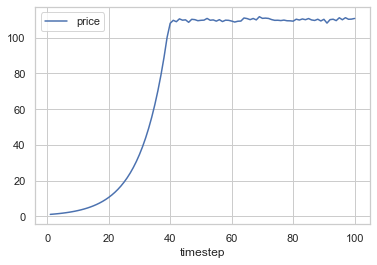

In [36]:
df[df.substep == 2].plot('timestep', ['price'])

<AxesSubplot:xlabel='timestep'>

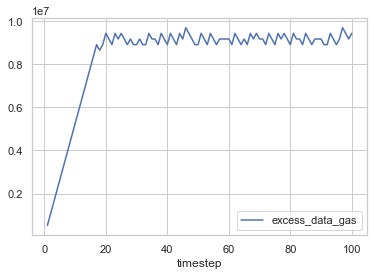

In [37]:
df[df.substep == 2].plot('timestep', ['excess_data_gas'])

<AxesSubplot:xlabel='timestep'>

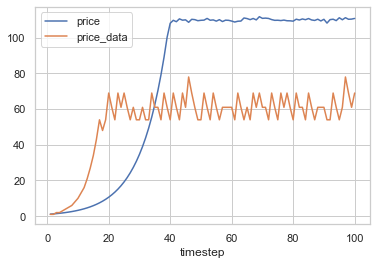

In [38]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price', 'price_data'])

# Backtest switching to blob txs

We now do a backtest considering the 98%+ percent of the current batch-data load that is given by Arbitrum and Optimism. We chose the day with the highest batch-data load in the first two months of 2023, February 24th.

- Arbitrum posted 1055 consistent batches of ~99kb (600b stdev) every 6.78 blocks on avg, for a total of ~100mb/day
- Optimism posted 2981 variable batches of avg ~31kb (19kb stdev) every 2.37 blocks on avg, for a total of ~93mb/day

Note that all gas accounting in 4844 is done using blobs and their fixed capacity size of 2**17b (~125kb).

**Case 1** considers a scenario with a data load which is slightly higher (1.5x) than the historical data from the peak day considered. For convenience, we assume that L2s do not optimize their batch sizes (okay for ARB but suboptimal for OP) which results in a likely overestimation of the blobs demand. Results show that this load is not enough to start moving the data price.

**Case 2** consider the case in which data load is inflated by roughly 10x, a value that is just enough to kickstart the data price discovery process.

We start with loading historical data (for original query and more stats for this data check out the data-processing-utils notebook in the same folder).

In [112]:
demand_input = pd.read_csv('4844-sample-new.csv', index_col=False)
demand_input.head()

,block_number,index,gas_used,max_fee,max_priority_fee,base_fee,data_tag,data_bytes,gas_used_calldata
0,16694584,14,104935,4.595416e+10,5.000000e+08,32301451293,other,132.0,2112.0
1,16694584,57,119600,4.140369e+10,1.000000e+09,32301451293,other,36.0,576.0
2,16694584,36,110595,4.600000e+10,2.000000e+09,32301451293,other,36.0,576.0
3,16694584,106,110595,4.595416e+10,5.000000e+08,32301451293,other,36.0,576.0
4,16694584,47,105818,6.848287e+10,1.109231e+09,32301451293,other,164.0,2624.0


## Case 1: historical demand x1.5

In [117]:
def generate_demand_from_data(params, step, h, s, _input):

    di = demand_input[demand_input['block_number']==(min(demand_input['block_number'])+len(h))].to_dict('index')

    demand = {}
    for key, val in di.items():
        if val['data_tag']=='other':
            tx = Transaction(
                gas_used = val['gas_used'],
                max_fee_per_gas = val['max_fee'],
                max_priority_fee_per_gas = val['max_priority_fee'],
            )
        else:
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = val['max_fee'],
                max_priority_fee_per_gas = val['max_priority_fee'],
                max_fee_per_data_gas = 50e9,
                blob_hashes = 1
            )
        demand[tx.tx_hash] = tx

    return ("demand", demand)


def build_block_from_data(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)
    
    # REMOVE selection, include everything for now
    sorted_valid_demand = [tx for tx_hash, tx in demand.items()]
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction) and utilized_data<=data_limit:
                included_transactions.append(tx)
                utilized += tx.gas_used
                utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
            elif isinstance(tx, BlobTransaction) and utilized_data>data_limit:
                continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [118]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand_from_data
    }
}, {
    "policies": {
        "action": build_block_from_data
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 28543674071,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 1600,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

In [127]:
df.tail(10)

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep,price_data
391,1.084784e+10,0,{b'\\\xb0\xdb\x85\x12\xed\x90D': <__main__.Tra...,<__main__.Block object at 0x138861f00>,0,0,1,2,391,1
392,1.089326e+10,0,"{b'\xd8\xd2,\x92 \x04\xcb)': <__main__.Transac...",<__main__.Block object at 0x13886e530>,0,0,1,2,392,1
393,1.044866e+10,0,{b'\xfbZJ\xdd\xdaO\xea\xe7': <__main__.Transac...,<__main__.Block object at 0x138881d80>,0,0,1,2,393,1
394,1.026659e+10,0,{b'\x8aP\x18\xa1\x1f\x8f\xfe\x08': <__main__.T...,<__main__.Block object at 0x13888e830>,0,0,1,2,394,1
395,1.066654e+10,0,{b'\xb7\xb3C\x11=O\xad#': <__main__.Transactio...,<__main__.Block object at 0x1388ac1f0>,0,0,1,2,395,1
396,1.093064e+10,262144,{b'\xba\xcb\xa7\xacs\xea\xe8i': <__main__.Tran...,<__main__.Block object at 0x1388b9450>,0,0,1,2,396,1
397,1.051280e+10,0,{b'\xb5\t\x18\xce\x187\x1d\x10': <__main__.Tra...,<__main__.Block object at 0x1388d1b40>,0,0,1,2,397,1
398,1.034515e+10,0,{b'\x85+8\x8aU0j\x19': <__main__.Transaction o...,<__main__.Block object at 0x1388e28c0>,0,0,1,2,398,1
399,9.331096e+09,0,{b'\x8aN\xd6\xad\x98\xbc\xac\xe1': <__main__.T...,<__main__.Block object at 0x1388e3e80>,0,0,1,2,399,1
400,1.013450e+10,0,{b'\xf9B.\x84\xa4\x0c)\t': <__main__.Transacti...,<__main__.Block object at 0x13890d990>,0,0,1,2,400,1


<AxesSubplot:>

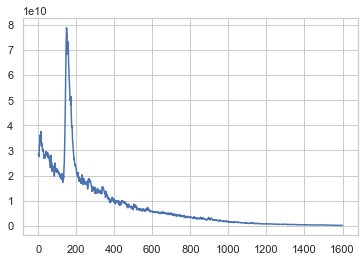

In [ ]:
df['price'].plot()

<AxesSubplot:xlabel='timestep'>

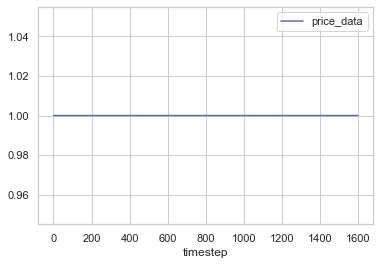

In [ ]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price_data'])

<AxesSubplot:xlabel='block_number'>

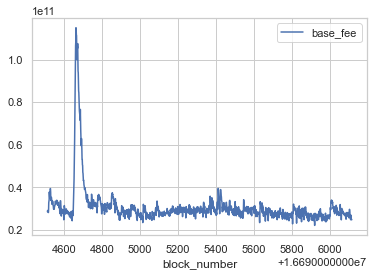

In [120]:
demand_input[['block_number', 'base_fee']].groupby('block_number').min().head(1600).plot()

Additional note: Comparing the gas price to the base fee from the original data we see that moving to batches to blobs as a deflationary effect on normal gas price (as expected).

## Case 2: historical demand x3 + 4 blobs every 3 blocks = historical demand ~x10

In [101]:
def generate_demand_from_data(params, step, h, s, _input):

    di = demand_input[demand_input['block_number']==(min(demand_input['block_number'])+len(h))].to_dict('index')
    
    demand = {}
    for key, val in di.items():
        if val['data_tag']=='other':
            tx = Transaction(
                gas_used = val['gas_used'],
                max_fee_per_gas = val['max_fee'],
                max_priority_fee_per_gas = val['max_priority_fee'],
            )
        else:
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = val['max_fee'],
                max_priority_fee_per_gas = val['max_priority_fee'],
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
        demand[tx.tx_hash] = tx
    
    if (len(h) % 3)==0:
        for i in range(2):
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = 150e9*uniform(0.75,1.25),
                max_priority_fee_per_gas = 1e9*uniform(1, 10),
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
            demand[tx.tx_hash] = tx

    return ("demand", demand)


def build_block_from_data(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)

    # select valid transactions and sort them by total gas premium
    # for BlobTransaction we check validity against price_data too
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price, price_data)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction) and utilized_data<=data_limit:
                included_transactions.append(tx)
                utilized += tx.gas_used
                utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
            elif isinstance(tx, BlobTransaction) and utilized_data>data_limit:
                continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [102]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand_from_data
    }
}, {
    "policies": {
        "action": build_block_from_data
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 28543674071,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 1600,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

In [103]:
df.tail(10)

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep
1591,1.799472e+08,54525952,{'9b31375c41e0': <__main__.Transaction object ...,<__main__.Block object at 0x13ff58130>,0,0,1,2,1591
1592,1.719275e+08,54263808,{'77bfa75cabbc': <__main__.Transaction object ...,<__main__.Block object at 0x13ff5ab30>,0,0,1,2,1592
1593,1.832515e+08,54788096,{'a90e2d8fcb83': <__main__.Transaction object ...,<__main__.Block object at 0x13ff73490>,0,0,1,2,1593
1594,1.780317e+08,54525952,{'6b808f278e10': <__main__.Transaction object ...,<__main__.Block object at 0x13ff8a170>,0,0,1,2,1594
1595,1.703862e+08,54263808,{'1d1bd0806647': <__main__.Transaction object ...,<__main__.Block object at 0x13ffa0c40>,0,0,1,2,1595
1596,1.672521e+08,54525952,{'e6eaf6fc8b8b': <__main__.Transaction object ...,<__main__.Block object at 0x13ffb83a0>,0,0,1,2,1596
1597,1.657340e+08,54525952,{'5bd93244031b': <__main__.Transaction object ...,<__main__.Block object at 0x13ffbbcd0>,0,0,1,2,1597
1598,1.647675e+08,54263808,{'a9ff4312bd5d': <__main__.Transaction object ...,<__main__.Block object at 0x13ffd3910>,0,0,1,2,1598
1599,1.619081e+08,54788096,{'ab7f2de6370c': <__main__.Transaction object ...,<__main__.Block object at 0x13ffebb80>,0,0,1,2,1599
1600,1.611968e+08,54525952,{'34bb61e7695a': <__main__.Transaction object ...,<__main__.Block object at 0x140002980>,0,0,1,2,1600


<AxesSubplot:xlabel='timestep'>

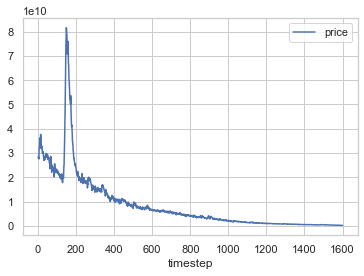

In [107]:
df[df.substep == 2].plot('timestep', ['price'])

<AxesSubplot:xlabel='timestep'>

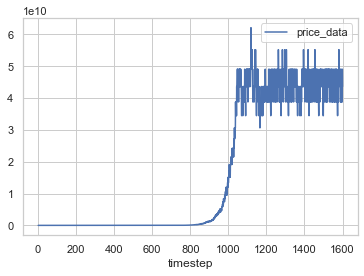

In [105]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price_data'])

## Resources

- [Dune query for explorations](https://dune.com/queries/2173699?sidebar=query-explorer)
- [Dan Boneh lecture on EVM resources](https://cs251.stanford.edu/lectures/lecture8.pdf)